# Giới thiệu 

Phân tích tình cảm đề cập đến việc xác định cũng như phân loại các tình cảm được thể hiện trong nguồn văn bản. Tweets thường hữu ích trong việc tạo ra một lượng lớn dữ liệu tình cảm khi phân tích. Những dữ liệu này rất hữu ích trong việc hiểu ý kiến của mọi người về nhiều chủ đề khác nhau.

Do đó, chúng tôi cần phát triển Mô hình phân tích tình cảm học máy tự động để tính toán nhận thức của khách hàng. Do sự hiện diện của các ký tự không hữu ích (collectively termed as the noise) cùng với dữ liệu hữu ích.

Mục đích của tôi là phân tích cảm xúc của các tweet được cung cấp từ bộ dữ liệu bằng cách phát triển một quy trình học máy liên quan đến việc sử dụng ba bộ phân loại (Hồi quy logistic, Bernoulli Naive Bayes và SVM) cùng với việc sử dụng Term Frequency- Inverse Document Frequency (TF-IDF ). 

# Problem Statement

Trong dự án này, tôi cố gắng triển khai mô hình phân tích tình cảm Twitter giúp vượt qua những thách thức trong việc xác định tình cảm của các tweet.

Các đặc tính liên quan đến tập dữ liệu là:

1. ids: ID mỗi Tweets

2. date: Thời gian đăng bình luận

3. flag: Nó đề cập đến truy vấn. Nếu không có truy vấn nào như vậy tồn tại thì không có câu hỏi.

4. user: Tên user đăng bình luận

5. text: Nội dung bình luận

6. Sentiment: Gán nhãn mỗi tweet

# Project Pipeline

Các bước thực hiện:

1. Import các thư viện cần thiết

2. Đọc và ghi tập dữ liệu 

3. Thông tin và kiểu dữ liệu

4. Trực quan hóa 

5. Tiền xử lí dữ liệu

6. Tách dữ liệu thành tập train, test

7. Chuyển đổi dữ liệu bằng TF-IDF Vectorizer

8. Xây dựng mô hình 

Kết luận

# Import Necessary Dependencies

In [193]:
# !pip install wordcloud
# !pip install seaborn
# !pip install sklearn
# !pip install nltk

In [230]:
import re
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import time

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# Read and Load the Dataset

In [231]:
# Importing the dataset
df = pd.read_csv('twitter.csv', encoding= "ISO-8859-1")
df.sample(5)

,ids,date,flag,user,text,Sentiment
19494,2193453573,Tue Jun 16 08:28:48 PDT 2009,NO_QUERY,RobNice24,@Sworn4DaBosses,Neutral
249,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy,Neutral
8984,1548555575,Fri Apr 17 21:16:58 PDT 2009,NO_QUERY,ilrosewood,@georgeb3dr Stick with the Intel drives or the...,Negative
12517,2191754188,Tue Jun 16 05:54:34 PDT 2009,NO_QUERY,HailSeitan,@MissAnthropy15 The Dogmother! :::snort::: I l...,Positive
17758,2193007863,Tue Jun 16 07:52:04 PDT 2009,NO_QUERY,moreilley,@ConsigliereTen I appreciate that,Neutral


# Exploratory Data Analysis 

3.1: Five top records of data

In [232]:
df.head()

,ids,date,flag,user,text,Sentiment
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Positive
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Neutral
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Positive
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Positive
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Negative


3.2: Columns/features in data

In [243]:
df.columns

Index(['ids', 'date', 'flag', 'user', 'text', 'Sentiment'], dtype='object')

3.3: Length of the dataset

In [234]:
print('Độ lớn của dataset:', len(df), "dòng")

Độ lớn của dataset: 20000 dòng


3.4: Shape of data

In [235]:
df. shape

(20000, 6)

3.5: Data information

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ids        20000 non-null  int64 
 1   date       20000 non-null  object
 2   flag       20000 non-null  object
 3   user       20000 non-null  object
 4   text       20000 non-null  object
 5   Sentiment  20000 non-null  object
dtypes: int64(1), object(5)
memory usage: 937.6+ KB


3.6: Datatypes of all columns

In [237]:
df.dtypes

ids           int64
date         object
flag         object
user         object
text         object
Sentiment    object
dtype: object

3.7: Checking for Null values

In [238]:
np.sum(df.isnull().any(axis=1))  #Đếm tổng số cột có giá trị null

0

3.8: Rows and columns in the dataset

In [239]:
print('Số cột: ', len(df.columns))
print('Số dòng:', len(df))

Số cột:  6
Số dòng: 20000


# Data Preprocessing 

Trong bài toán được đưa ra ở trên, trước khi huấn luyện mô hình, tôi đã thực hiện một số bước tiền xử lý trên tập dữ liệu, chủ yếu liên quan đến việc loại bỏ stopword (từ dừng), loại bỏ emojis (biểu tượng cảm xúc). Sau đó, văn bản được chuyển đổi thành chữ thường để tăng tính tổng quát hóa.

Tiếp theo, dấu câu được làm sạch và loại bỏ, giúp giảm bớt các nhiễu không cần thiết trong tập dữ liệu. Sau đó, chúng tôi cũng loại bỏ các ký tự lặp lại trong từ cũng như loại bỏ các URL vì chúng không có ý nghĩa quan trọng.

Cuối cùng, chúng tôi đã thực hiện Stemming (giảm từ xuống dạng gốc của chúng) và Lemmatization (giảm các từ xuống dạng gốc gọi là "lemma") để đạt được kết quả tốt hơn.

4.1: Selecting the text and Target column for our further analysis

In [244]:
data=df[['text','Sentiment']]
data

,text,Sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Positive
1,is upset that he can't update his Facebook by ...,Neutral
2,@Kenichan I dived many times for the ball. Man...,Positive
3,my whole body feels itchy and like its on fire,Positive
4,"@nationwideclass no, it's not behaving at all....",Negative
...,...,...
19995,Just woke up. Having no school is the best fee...,Positive
19996,TheWDB.com - Very cool to hear old Walt interv...,Positive
19997,Are you ready for your MoJo Makeover? Ask me f...,Positive
19998,Happy 38th Birthday to my boo of alll time!!! ...,Positive


4.2: Recode Sentiment

In [245]:
def recode(text):
    if text == "Positive": return 1 
    elif text == "Neutral": return 0
    else: return -1
data["Sentiment"] = data["Sentiment"].apply(lambda text: recode(text))
data.Sentiment.dtype


C:\Users\haina\AppData\Local\Temp/ipykernel_16228/982060764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Sentiment"] = data["Sentiment"].apply(lambda text: recode(text))


dtype('int64')

4.3: Print unique values of target variables

In [246]:
data['Sentiment'].unique()

array([ 1,  0, -1], dtype=int64)

4.4: Making statement text in lower case

In [247]:
data['text']=data['text'].str.lower()
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_16228/671079150.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text']=data['text'].str.lower()


0        @switchfoot http://twitpic.com/2y1zl - awww, t...
1        is upset that he can't update his facebook by ...
2        @kenichan i dived many times for the ball. man...
3          my whole body feels itchy and like its on fire 
4        @nationwideclass no, it's not behaving at all....
                               ...                        
19995    just woke up. having no school is the best fee...
19996    thewdb.com - very cool to hear old walt interv...
19997    are you ready for your mojo makeover? ask me f...
19998    happy 38th birthday to my boo of alll time!!! ...
19999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 20000, dtype: object

4.5: Cleaning and removing the above stop words list from the tweet text

In [248]:
nltk.download("stopwords")
list_stopwords = set(stopwords.words("english"))
print(list_stopwords)

{'here', 've', 'your', 'once', 'o', "that'll", 'wouldn', 'doing', 'off', 'can', 'any', "wouldn't", 'needn', 'further', 'only', 'than', 'for', 't', "aren't", 'myself', 'after', 'him', 'the', 'under', 'most', 'will', 'they', 'won', 'is', 'was', 'when', 'too', 'you', 'with', 'she', 'above', 'herself', 'how', 'our', 'have', 'own', 'other', 'hers', 'below', 'them', 'until', 'hasn', 'do', "shouldn't", 'we', 'same', 'are', 'to', 'isn', 'what', 'doesn', "you're", 'mightn', 'more', 'mustn', 'or', "didn't", "shan't", 'has', 'ain', 'haven', 'yourselves', "weren't", 'over', 'whom', "she's", 'about', 'on', 'nor', 'himself', 'no', 'itself', "don't", 'before', "you'd", 'into', 'who', 'an', 'while', 'up', "it's", 'shan', 'ourselves', 'll', 'theirs', 'between', 'ma', "hasn't", "wasn't", 'where', 're', 'just', 'that', "won't", 'by', 'not', 'did', 'my', 'being', 'through', 'now', 'from', "haven't", 'y', 'hadn', 'then', 'aren', 'his', "couldn't", 'each', 'because', 'm', "isn't", 'it', 'be', 'a', 'which', 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [249]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in list_stopwords])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_16228/2095209452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))


0        @switchfoot http://twitpic.com/2y1zl - awww, t...
1        upset can't update facebook texting it... migh...
2        @kenichan dived many times ball. managed save ...
3                         whole body feels itchy like fire
4        @nationwideclass no, behaving all. i'm mad. he...
                               ...                        
19995                    woke up. school best feeling ever
19996    thewdb.com - cool hear old walt interviews! ã¢...
19997                     ready mojo makeover? ask details
19998    happy 38th birthday boo alll time!!! tupac ama...
19999    happy #charitytuesday @thenspcc @sparkscharity...
Name: text, Length: 20000, dtype: object

4.6: Cleaning and removing punctuations

In [250]:
import string
english_punctuations = string.punctuation   # Kí tự đặc biệt
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    for i in punctuations_list:
        text = text.replace(i, "")
    return text
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_16228/704957818.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))


0        switchfoot httptwitpiccom2y1zl  awww thats bum...
1        upset cant update facebook texting it might cr...
2        kenichan dived many times ball managed save 50...
3                         whole body feels itchy like fire
4        nationwideclass no behaving all im mad here ca...
                               ...                        
19995                     woke up school best feeling ever
19996    thewdbcom  cool hear old walt interviews ã¢ââ...
19997                      ready mojo makeover ask details
19998    happy 38th birthday boo alll time tupac amaru ...
19999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 20000, dtype: object

4.7: Cleaning and removing URL’s

In [251]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_16228/2110461099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))


0        switchfoot httptwitpiccomyzl a s bummer should...
1        upset cant updat facebook text it might cri re...
2        kenichan dive mani time ball manag save rest g...
3                          whole bodi feel itchi like fire
4        nationwideclass no behav all im mad here cant ...
                               ...                        
19995                        woke up school best feel ever
19996    thewdbcom cool hear old walt interview ã â â h...
19997                         readi mojo makeov ask detail
19998    happi th birthday boo alll time tupac amaru sh...
19999    happi charitytuesday thenspcc sparkschar speak...
Name: text, Length: 20000, dtype: object

4.8: Cleaning and removing Numeric numbers

In [252]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_16228/1966440224.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))


0        switchfoot httptwitpiccomyzl a s bummer should...
1        upset cant updat facebook text it might cri re...
2        kenichan dive mani time ball manag save rest g...
3                          whole bodi feel itchi like fire
4        nationwideclass no behav all im mad here cant ...
                               ...                        
19995                        woke up school best feel ever
19996    thewdbcom cool hear old walt interview ã â â h...
19997                         readi mojo makeov ask detail
19998    happi th birthday boo alll time tupac amaru sh...
19999    happi charitytuesday thenspcc sparkschar speak...
Name: text, Length: 20000, dtype: object

4.9: Getting tokenization of tweet text

In [253]:
# Chuyển dạng str sang list
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_16228/2503317809.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(tokenizer.tokenize)


0        [switchfoot, httptwitpiccomyzl, a, s, bummer, ...
1        [upset, cant, updat, facebook, text, it, might...
2        [kenichan, dive, mani, time, ball, manag, save...
3                   [whole, bodi, feel, itchi, like, fire]
4        [nationwideclass, no, behav, all, im, mad, her...
                               ...                        
19995                 [woke, up, school, best, feel, ever]
19996    [thewdbcom, cool, hear, old, walt, interview, ...
19997                   [readi, mojo, makeov, ask, detail]
19998    [happi, th, birthday, boo, alll, time, tupac, ...
19999    [happi, charitytuesday, thenspcc, sparkschar, ...
Name: text, Length: 20000, dtype: object

4.10: Applying Stemming

In [254]:
# Đưa từ vè dạng gốc
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text']

C:\Users\haina\AppData\Local\Temp/ipykernel_16228/2448988428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text']= data['text'].apply(lambda x: stemming_on_text(x))


0        [switchfoot, httptwitpiccomyzl, a, s, bummer, ...
1        [upset, cant, updat, facebook, text, it, might...
2        [kenichan, dive, mani, time, ball, manag, save...
3                   [whole, bodi, feel, itchi, like, fire]
4        [nationwideclass, no, behav, all, im, mad, her...
                               ...                        
19995                 [woke, up, school, best, feel, ever]
19996    [thewdbcom, cool, hear, old, walt, interview, ...
19997                   [readi, mojo, makeov, ask, detail]
19998    [happi, th, birthday, boo, alll, time, tupac, ...
19999    [happi, charitytuesday, thenspcc, sparkschar, ...
Name: text, Length: 20000, dtype: object

4.11: Applying Lemmatizer

In [255]:
# Đưa về từ đại diện cho nhóm từ 
nltk.download('wordnet')

lemmatizer = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lemmatizer.lemmatize(word) for word in data]
    return text
data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text']

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\haina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\haina\AppData\Local\Temp/ipykernel_16228/1545070245.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))


0        [switchfoot, httptwitpiccomyzl, a, s, bummer, ...
1        [upset, cant, updat, facebook, text, it, might...
2        [kenichan, dive, mani, time, ball, manag, save...
3                   [whole, bodi, feel, itchi, like, fire]
4        [nationwideclass, no, behav, all, im, mad, her...
                               ...                        
19995                 [woke, up, school, best, feel, ever]
19996    [thewdbcom, cool, hear, old, walt, interview, ...
19997                   [readi, mojo, makeov, ask, detail]
19998    [happi, th, birthday, boo, alll, time, tupac, ...
19999    [happi, charitytuesday, thenspcc, sparkschar, ...
Name: text, Length: 20000, dtype: object

4.12: Convert list to str

In [256]:
for i in range(len(dataset.text)):
    data.text[i] = " ".join(data.text[i])
data

C:\Users\haina\AppData\Local\Temp/ipykernel_16228/675745941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.text[i] = " ".join(data.text[i])


,text,Sentiment
0,switchfoot httptwitpiccomyzl a s bummer should...,1
1,upset cant updat facebook text it might cri re...,0
2,kenichan dive mani time ball manag save rest g...,1
3,whole bodi feel itchi like fire,1
4,nationwideclass no behav all im mad here cant ...,-1
...,...,...
19995,woke up school best feel ever,1
19996,thewdbcom cool hear old walt interview ã â â h...,1
19997,readi mojo makeov ask detail,1
19998,happi th birthday boo alll time tupac amaru sh...,1


# Data Visualization of Target Variables

5.1 Count sample of each targets

In [257]:
print("Số sample tích cực: ", data[data["Sentiment"] == 1]["Sentiment"].count())
print("Số sample trung lập: ", data[data["Sentiment"] == 0]["Sentiment"].count())
print("Số sample tiêu cực: ", data[data["Sentiment"] == -1]["Sentiment"].count())


Số sample tích cực:  8660
Số sample trung lập:  7022
Số sample tiêu cực:  4318


5.2 Bar chart: So sánh số lượng các tweets được gán nhãn

[Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')]

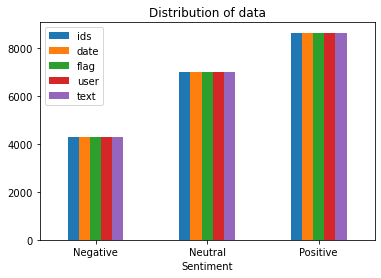

In [222]:
ax = df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',legend=True)
ax.set_xticklabels(['Negative','Neutral', "Positive"], rotation=0)

5.3 Pie chart: So sánh tỉ lệ các tweets được gán nhãn

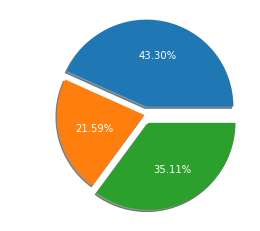

In [258]:
# Đếm xem có bao nhiêu nhãn cảm xúc trong tất cả các tweets
a=len(data[data["Sentiment"] == 1])
b=len(data[data["Sentiment"] == -1])
c=len(data[data["Sentiment"] == 0])
d=np.array([a,b,c])
explode = (0.1, 0.0, 0.1)
plt.pie(d,shadow=True,explode=explode,labels=["Positive","Negative","Neutral"],autopct='%1.2f%%', textprops={'color': 'white', 'fontsize': 10});

Qua 2 biểu đồ cột và biểu đồ tròn chúng ta có thể thấy số tweets mang cảm xúc tích cực chiếm tỉ lệ cao nhất: 43.03%, tiếp theo là tweets mang cảm xúc trung lập chiếm khoảng 35.11% và trong dataset này số tweets mang cảm xúc tiêu cực thấp nhất, chỉ chiểm khoảng 21.59%

5.4: Plot a cloud of words for positive tweets

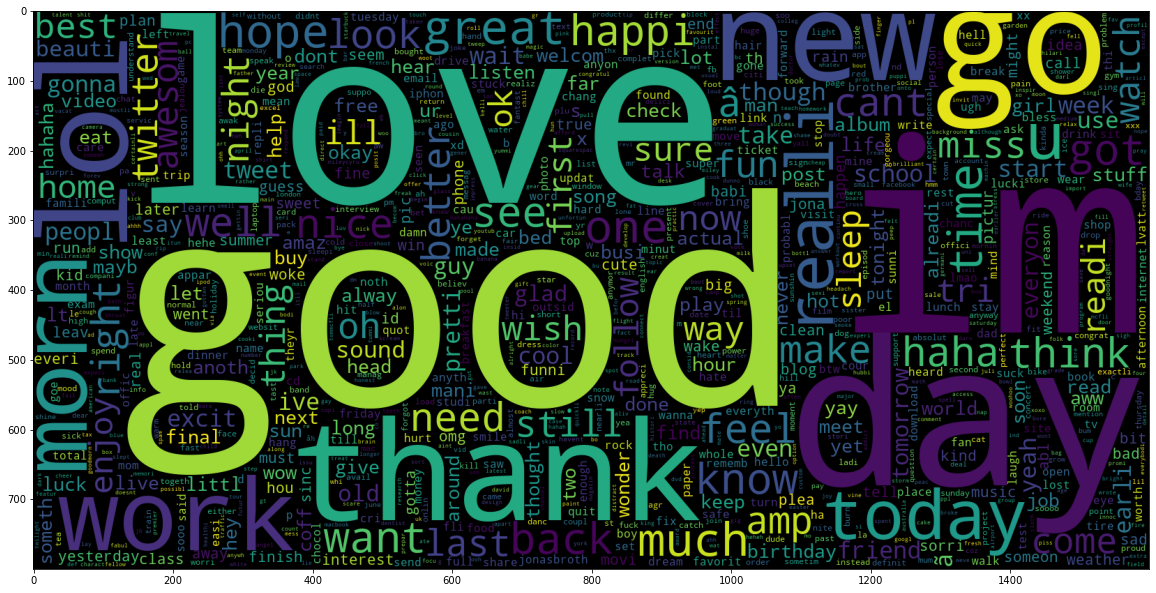

In [259]:
data_pos = (data[data['Sentiment'] == 1]["text"])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
# Tham số collocations: hiển thị các cụm từ phổ biến 
plt.imshow(wc)

5.5: Plot a cloud of words for neutral tweets

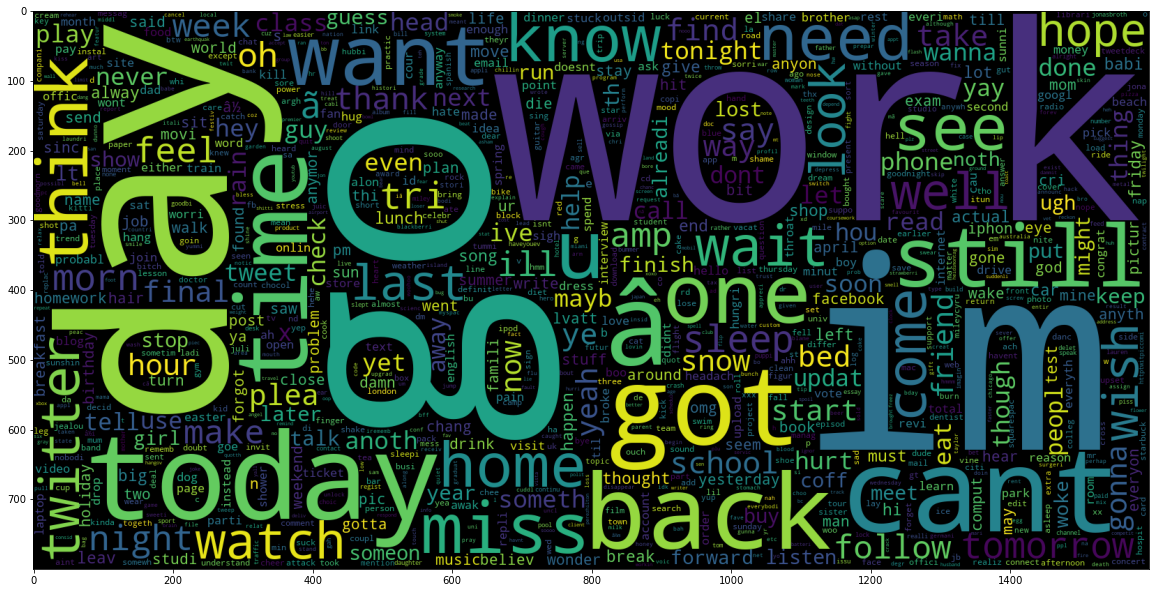

In [261]:
data_neu = (data[data['Sentiment'] == 0]["text"])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neu))
# Tham số collocations: hiển thị các cụm từ phổ biến 
plt.imshow(wc)

5.6: Plot a cloud of words for negative tweets

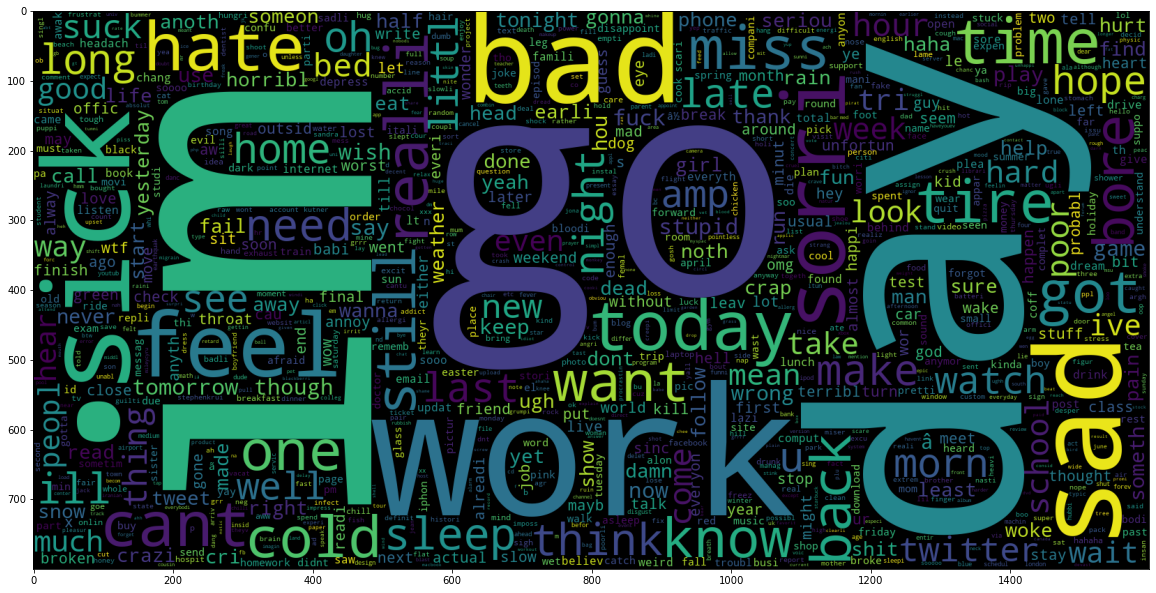

In [262]:
data_neg = (data[data['Sentiment'] == -1]["text"])
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000, width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
# Tham số collocations: hiển thị các cụm từ phổ biến 
plt.imshow(wc)

# Splitting our data into Train and Test Subset

In [263]:
X=data.text
y=data.Sentiment
print(X, y)

0        switchfoot httptwitpiccomyzl a s bummer should...
1        upset cant updat facebook text it might cri re...
2        kenichan dive mani time ball manag save rest g...
3                          whole bodi feel itchi like fire
4        nationwideclass no behav all im mad here cant ...
                               ...                        
19995                        woke up school best feel ever
19996    thewdbcom cool hear old walt interview ã â â h...
19997                         readi mojo makeov ask detail
19998    happi th birthday boo alll time tupac amaru sh...
19999    happi charitytuesday thenspcc sparkschar speak...
Name: text, Length: 20000, dtype: object 0        1
1        0
2        1
3        1
4       -1
        ..
19995    1
19996    1
19997    1
19998    1
19999    1
Name: Sentiment, Length: 20000, dtype: int64


In [216]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =203)
print("Length of X_train: ", len(X_train))
print("Length of X_test: ", len(X_test))

Length of X_train:  18000
Length of X_test:  2000


# Transforming Dataset using TF-IDF Vectorizer

Transform the data using TF-IDF Vectorizer

In [217]:
#  Ma trận TF-IDF
vectoriser = TfidfVectorizer()         #max_features=5000, min_df=5, max_df=0.9 
vectoriser.fit_transform(X_train)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print('Count of feature_words: ', len(vectoriser.get_feature_names()))




Count of feature_words:  24810


# Model Building

Trong báo cáo vấn đề, tôi đã sử dụng ba mô hình khác nhau tương ứng :

1. Bernoulli Naive Bayes

2. SVM (Support Vector Machine)

3. Logistic Regression


8.1: Model-1

In [218]:
start = time.time()
# Tạo mô hình BernoulliNB
model = BernoulliNB()
model.fit(X_train, y_train)

# Dự đoán kết quả trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Tính độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
finish = time.time()
print('Độ chính xác của mô hình: {:.2f}%'.format(accuracy * 100))
print("Thời gian chạy: ", finish-start)

# Đánh giá mô hình bằng báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 74.70%
Running time:  0.01895451545715332
Classification Report:
              precision    recall  f1-score   support

          -1       0.91      0.25      0.39       426
           0       0.78      0.82      0.80       698
           1       0.71      0.93      0.80       876

    accuracy                           0.75      2000
   macro avg       0.80      0.67      0.66      2000
weighted avg       0.78      0.75      0.71      2000



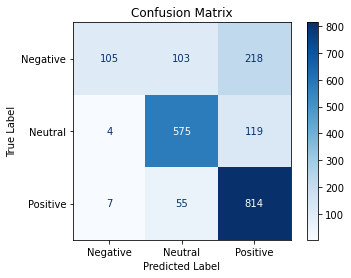

In [219]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Biểu diễn ma trận nhầm lẫn bằng ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Thiết lập tham số cho TfidfVectorizer giúp loại bỏ data thưa thớt, không mang lại nhiều ý**


In [221]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =203)
vectoriser = TfidfVectorizer (max_features=5000, min_df=4)
vectoriser.fit_transform(X_train)
X_train = vectoriser.fit_transform(X_train)
X_test = vectoriser.transform(X_test)
print('Số feature_words: ', len(vectoriser.get_feature_names()))

Count of feature_words:  3516


**Ta có thể thấy, độ chính xác vẫn còn thấp, thuật toán chạy chậm vì số lượng features quá lớn: 24810. Chúng ta có thể giảm số lượng features để thuật toán học nhanh hơn**.

- Thiết lập tham số max_features=5000 trong lúc tạo đối tượng TfidfVectorizer. Tuy nhiên cách này sẽ mất đi nhiều từ có ý nghĩa trong từ điển.
- Thiết lập tham số min_df=4 để loại bỏ những feature có số lượng từ tần suất xuất hiện ít hơn 4 lần.
  Số feature ban đầu 24810. Sau khi tối ưu, số feature là 3516.
  


Chạy lại model

In [222]:
start = time.time()
# Tạo mô hình BernoulliNB
model = BernoulliNB()
model.fit(X_train, y_train)

# Dự đoán kết quả trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Tính độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
finish = time.time()
print('Độ chính xác của mô hình: {:.2f}%'.format(accuracy * 100))

print("Thời gian chạy: ", finish-start)

# Đánh giá mô hình bằng báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 82.55%
Running time:  0.013956546783447266
Classification Report:
              precision    recall  f1-score   support

          -1       0.78      0.67      0.72       426
           0       0.81      0.88      0.85       698
           1       0.86      0.85      0.86       876

    accuracy                           0.83      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.82      0.83      0.82      2000



  Chúng ta có thể loại bỏ đáng kể feature xuất hiện ít dẫn đến gây nhiễu dữ liệu. Độ chính xác thuật toán tăng từ 74.7% lên 82.55%.
Thời gian chạy thuật toán cũng nhanh hơn. Khác biệt khi chạy thuật toán với số lượng feature lớn và số lần chạy thuật toán lớn.

=> Không phải lúc nào dùng nhiều data để học cũng tốt.


8.2: Model-2:

In [226]:
start = time.time()

# Tạo mô hình LinearSVC
model = LinearSVC()
model.fit(X_train, y_train)

# Dự đoán kết quả trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Tính độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
finish = time.time()
print('Độ chính xác của mô hình: {:.2f}%'.format(accuracy * 100))

print("Thơi gian chạy: ", finish-start)

# Đánh giá mô hình bằng báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 86.05%
Running time:  0.2722609043121338
Classification Report:
              precision    recall  f1-score   support

          -1       0.85      0.76      0.80       426
           0       0.81      0.92      0.86       698
           1       0.92      0.86      0.89       876

    accuracy                           0.86      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.86      0.86      2000



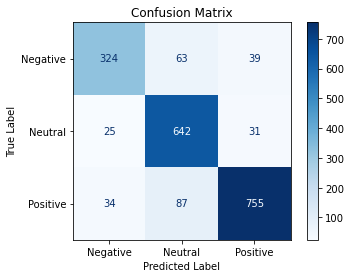

In [227]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Biểu diễn ma trận nhầm lẫn bằng ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

8.3. Model-3

In [228]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

# Tạo mô hình LinearSVC
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Dự đoán kết quả trên dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Tính độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
finish = time.time()
print('Độ chính xác của mô hình: {:.2f}%'.format(accuracy * 100))

print("Thời gian chạy: ", finish-start)

# Đánh giá mô hình bằng báo cáo phân loại
print("Báo cáo phân loại:")
print(classification_report(y_test, y_pred))

Độ chính xác của mô hình: 86.60%
Running time:  15.266341209411621
Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.70      0.78       426
           0       0.83      0.95      0.89       698
           1       0.90      0.88      0.89       876

    accuracy                           0.87      2000
   macro avg       0.87      0.84      0.85      2000
weighted avg       0.87      0.87      0.86      2000



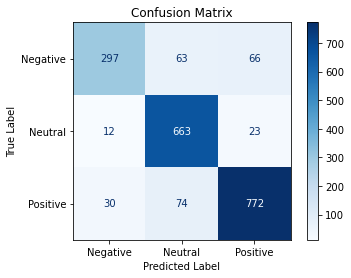

In [229]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Biểu diễn ma trận nhầm lẫn bằng ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()